In [1]:
# Load libraries and data files
###############################################################
library(data.table)
load('../data/exonicvsnon_counts.rda') # Probabilities of each mutation type
load('../data/gene_pdt.rda') # Load tables giving probability of insertion for each gene in a diploid genome for both genders
xy_genes <- gene_pdt_m$geneSym[gene_pdt_m$chrom %in% c('X','Y')] # Getting list of genes on chroms. X and Y by symbol

# Define functions
###############################################################
#--- birthrate()
birthrate <- function(nd_het, np_het, nd_hom, np_hom, sld, slp, spd, spp, tau) { # probability of birth per timestep   
    return(((((1+sld)^nd_het)*((1+spd)^nd_hom))/(((1+slp)^np_het)*((1+spp)^np_hom)))*tau)
}

#--- delta_ncells()
delta_ncells <- function(B, D, ncells) { # change in number of cells for a clone
    return (max(ncells + rbinom(1,ncells,min(B,1))-rbinom(1,ncells,min(D,1)),0))
}

#--- get_mu_i()
get_mu_i <- function(B, mu) {return(mu*B)} # mutation rate of clone i: proportional to birth rate

#--- get_nins()
get_nins <- function(ncells, mu_i) {return (rbinom(1,ncells,mu_i))} # number of insertions in current clone

#--- update_mcount()
update_mcount <- function(nd_het,np_het,nd_hom,np_hom,typemut,typegene) {
    
    if (typemut==2 & typegene==0) {return(list(nd_het,np_het+1,nd_hom,np_hom)) # If heterozygous passenger mutation (most likely)
    } else if (typemut==1) {return(c(nd_het,np_het,nd_hom,np_hom)) # If no-effect (redundant) mutation
    } else if (typemut==2 & typegene==1) {return(list(nd_het+1,np_het,nd_hom,np_hom)) # If heterozygous driver mutation 
    } else if (typemut==3 & typegene==0) {return(list(nd_het,np_het-1,nd_hom,np_hom+1)) # If homozygous passenger
    } else if (typemut==3 & typegene==1) {return(list(nd_het-1,np_het,nd_hom+1,np_hom))} # If homozygous driver
    
}

#--- update_genes_m()
# This function will update the gene lists for a given clone, for a male genome
# type 1 - no effect
# type 2 - heterozygous effect
# type 3 - homozygous effect
update_genes_m <- function(genes_het,genes_hom) {
    if (tail(genes_het,1) %in% genes_hom) { # If the last gene in list is in list of homoz. disrupted genes, discard it
        genes_het <- head(genes_het,length(genes_het)-1)
        type<-1
    } else {
        if (tail(genes_het,1) %in% head(genes_het,length(genes_het)-1)) { # If the last gene is in the list of heteroz. disrupted genes
            if (tail(genes_het,1) %in% xy_genes) { # If it's an X or Y chrom. gene
                genes_het <- head(genes_het,length(genes_het)-1)
                type<-1
            }
            else if (sample(c(0,1),1)) { # With 50% probability, assume it's the other copy, add the gene to the homoz. list, and discard it (all instances) from heteroz. list
                genes_hom <- append(genes_hom,tail(genes_het,1))
                genes_het <- genes_het[genes_het!=tail(genes_het,1)]
                type<-3
            } else { # Else, assume it hit already disrupted copy, and discard from list
                genes_het <- head(genes_het,length(genes_het)-1)
                type<-1
            }
        } else {
            if (tail(genes_het,1) %in% xy_genes) { # If it's an X or Y chrom. gene
                type<-3
            } else {
                type<-2
            }
        }
    }
      return(list(genes_het,genes_hom,type))
    
}

#--- update_genes_f()
# This function will update the gene lists for a given clone, for a female genome
# type 1 - no effect
# type 2 - heterozygous effect
# type 3 - homozygous effect
update_genes_f <- function(genes_het,genes_hom) {
    if (tail(genes_het,1) %in% genes_hom) { # If the last gene in list is in list of paired disrupted genes, discard it
        genes_het <- head(genes_het,length(genes_het)-1)
        type<-1
    } else {
        if (tail(genes_het,1) %in% head(genes_het,length(genes_het)-1)) { # If the last gene is in the list of lone disrupted genes
            if (sample(c(0,1),1)) { # With 50% probability, assume it's the other copy, add the gene to the paired list, and discard it (all instances) from lone list
                genes_hom <- append(genes_hom,tail(genes_het,1))
                genes_het <- genes_het[genes_het!=tail(genes_het,1)]
                type<-3
            } else { # Else, assume it hit already disrupted copy, and discard from list
                genes_het <- head(genes_het,length(genes_het)-1)
                type<-1
            }
        } else {
            type<-2
        }
    }
      return(list(genes_het,genes_hom,type))
    
}

#--- run_sim()
run_sim <- function(N0, mu, tau, NT, sld, slp, spd, spp, gender, driverGene, geneList, nclones, logpath) {

    if (gender=='male') {
        gene_pdt <- gene_pdt_m
        update_genes <- update_genes_m
    } else if (gender=='female') {
        gene_pdt <- gene_pdt_f
        update_genes <- update_genes_f
    } else {stop('Argument gender must be \'male\' or \'female\'.')}
    
    gene_pdt$type[gene_pdt$geneSym %in% geneList] <- 1
    write(paste0(toString(length(which(gene_pdt$type==1))),' out of ',length(geneList),' driver genes found in gene_pdt.'),file=logpath,append=TRUE)
    
    # Allocate population
    Pop <- data.table(ncells=rep(0,nclones),
                      B=rep(0,nclones),
                      mu_i=rep(0,nclones),
                      nd_het=rep(0,nclones),
                      np_het=rep(0,nclones),
                      nd_hom=rep(0,nclones),
                      np_hom=rep(0,nclones),
                      genes_het=rep(list(''),nclones),
                      genes_hom=rep(list(''),nclones),
                      lasttype=rep(0,nclones))
    # Initialize population with a heterozygous driver mutation
#     Pop[1:2,c('ncells','nd_het','np_het','nd_hom','np_hom','genes_het','genes_hom','lasttype'):=list(c(N0-1,1),
#                                                                                  c(0,1),
#                                                                                  c(0,0),
#                                                                                  c(0,0),
#                                                                                  c(0,0),
#                                                                                  list(c(''),c(driverGene)),
#                                                                                  list(c(''),c('')),
#                                                                                  c(0,1))]
    
    # Initialize population with no mutations
    Pop[1,c('ncells','nd_het','np_het','nd_hom','np_hom','genes_het','genes_hom','lasttype'):=list(c(N0),
                                                                                 c(0),
                                                                                 c(0),
                                                                                 c(0),
                                                                                 c(0),
                                                                                 list(c('')),
                                                                                 list(c('')),
                                                                                 c(0))]
    
#     # Assign birth and insertion rates
    Pop[1:2, B := mapply(birthrate, nd_het, np_het, nd_hom, np_hom, sld, slp, spd, spp, tau)]
    Pop[1:2, mu_i := mapply(get_mu_i, B, mu)]
    # For if the population data table needs to be enlarged
    bkup_Pop <- data.table(ncells=rep(0,nclones),
                      B=rep(0,nclones),
                      mu_i=rep(0,nclones),
                      nd_het=rep(0,nclones),
                      np_het=rep(0,nclones),
                      nd_hom=rep(0,nclones),
                      np_hom=rep(0,nclones),
                      genes_het=rep(list(''),nclones),
                      genes_hom=rep(list(''),nclones),
                      lasttype=rep(0,nclones))
    
    N <- rep(0,NT) # Allocate array for population size time series
    genes <- character(nrow(gene_pdt))
    write('Initialized...',file=logpath,append=TRUE)

    ptm <- proc.time()
    for (ii in 1:NT) { # Loop over time steps
        if(ii %in% c(round(NT/4),round(NT/4*2),round(NT/4*3),NT)) { # Print progress at 25% completed intervals
            write(paste0(toString(ii/NT*100),'% done | ',format((proc.time()-ptm)[1],nsmall=3),' (s)'),file=logpath,append=TRUE)            
        }
        
        N[ii] <- sum(Pop$ncells) # Get current number of cells
        if (N[ii]>=3*N0 || N[ii]<1) {break} # Simulation stops if population has grown by 3X or died
        D <- N[ii]*tau/N0        # Compute death rate
        
        clog <- Pop$ncells>0 # Get logical array for indices of active (# cells >0) clones
        
        nins <- sum(unlist(mapply(get_nins,Pop$ncells[clog],Pop$mu_i[clog],SIMPLIFY=FALSE))) # Get number of exonic insertions
        if (nins > 0) {
            
            rownew <- which(Pop$ncells==0)[1] # Find first row of the data table with ncells==0
            
            gene_ids <- sample(1:nrow(gene_pdt),nins,replace=TRUE,prob=gene_pdt$p)
            gene_list <- gene_pdt$geneSym[gene_ids]
            genes<-append(genes,gene_list)
            genetypes <- gene_pdt$type[gene_ids]

            clonesWIns <- sample(rep(1:nclones,Pop$ncells), nins, replace=FALSE, prob=rep(Pop$mu_i,Pop$ncells)) # List clone id (row number) of each cell; sample without replacement
            ctab <- table(clonesWIns)
            cids <- as.integer(names(ctab)) # Get row ids of sampled clones
            set(Pop,cids,1L,Pop[cids,1L] - as.integer(ctab)) # Remove cells from sampled clones

            # Populate the new rows representing new clones
            if(rownew+nins-1>nrow(Pop)){ # Enlarge the population data object if needed
                Pop<-rbind(Pop,bkup_Pop)
                write('Increased size of pop. object',file=logpath,append=TRUE)
            }
            new_inds <- rownew:(rownew+nins-1) # Row indices of new rows            
            Pop[new_inds, c("ncells","nd_het","np_het","nd_hom","np_hom","genes_het","genes_hom","lasttype"):=list(1, 
                                                                                                Pop$nd_het[clonesWIns], 
                                                                                                Pop$np_het[clonesWIns], 
                                                                                                Pop$nd_hom[clonesWIns], 
                                                                                                Pop$np_hom[clonesWIns], 
                                                                                                mapply(append,Pop$genes_het[clonesWIns],gene_list,SIMPLIFY=FALSE),
                                                                                                Pop$genes_hom[clonesWIns],
                                                                                                genetypes)]
            # Update gene lists
            tmp1 <- t(mapply(update_genes,Pop$genes_het[new_inds],Pop$genes_hom[new_inds],SIMPLIFY=TRUE))
            Pop$genes_het[new_inds] <- tmp1[,1]
            Pop$genes_hom[new_inds] <- tmp1[,2]
            # Update insertion counts
            tmp2<-t(mapply(update_mcount,Pop$nd_het[new_inds],Pop$np_het[new_inds],Pop$nd_hom[new_inds],Pop$np_hom[new_inds],tmp1[,3],Pop$lasttype[new_inds]))
            Pop[new_inds,c("nd_het","np_het","nd_hom","np_hom"):=list(unlist(tmp2[,1]),unlist(tmp2[,2]),unlist(tmp2[,3]),unlist(tmp2[,4]))]
            # Update birth and insertion rates
            Pop[new_inds, B := mapply(birthrate, nd_het, np_het, nd_hom, np_hom, sld, slp, spd, spp, tau)]
            Pop[new_inds, mu_i := mapply(get_mu_i, B, mu)]
        }
        
        Pop[Pop$ncells>0, ncells:=mapply(delta_ncells, B, D, ncells)] # Update number of cells for all clones
        Pop <- Pop[order(Pop$ncells,decreasing=TRUE),] # Order data.table by ncells

    }
    print(proc.time() - ptm)
    genes <- genes[!is.na(genes)]
    Pop <- Pop[,1:9]
    return(list(Pop,N,genes))

}

#--- get_drivers()
get_drivers <- function(cancer_type){
    
    geneList <- read.csv('../data/Census_allThu Sep 13 17_30_17 2018.csv') # Cancer Gene Census Data Table
    if (cancer_type=='lung') {
        toMatch <- c('lung')
    } else if (cancer_type=='colon') {
        toMatch <- c('colon','colorectal')
    } else if (cancer_type=='brain') {
        toMatch <- c('astrocytoma','meningioma','head','oligodendroglio')
    }
    # Get genes affecting chosen cancer type
    geneList<-geneList[grep(paste(toMatch,collapse='|'),geneList$Tumour.Types.Somatic),]
    # Filter for only Tier 1 genes
#     geneList<-geneList[geneList$Tier==1,]
    # Filter for TSGs
    geneList<-geneList[grep('TSG',geneList$Role.in.Cancer),]
    geneList <- as.vector(geneList$Gene.Symbol)
    
    return(geneList)
}


### Define parameters

In [2]:
###################################################3
# Gender of organism
gender <- 'male'

# Symbol of driver gene disrupted at t=0
driverGene <- ''

# List of driver genes
geneList <- get_drivers('brain')

# Initial number of cells
N0 <- 1000

# Average # L1 insertions / cell cycle
mu <- 1
if (gender=='male') {
    mu <- mu*(1-pd_exvsnon_m[2])# Scale by 1-probability of null (intron) insertion, to convert to probability of exonic insertion
} else if (gender=='female') {
    mu <- mu*(1-pd_exvsnon_f[2])
}

# Selective strengths of each mutation type
spd <- .1 # Homozygous driver
spp <- .005 # Homozygous passenger
sld <- spd*0.1 # Heterozygous driver
slp <- spp*0.1 # Hetero. passenger

# Number of time steps to simulate
NT <- 2e4

###################################################3
# Time resolution: number of timesteps per generation
tau <- 4
tau <- 1/tau
# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- N0*4
# Log path
logpath <- './test_v2.3.log'
system(paste0('rm ',logpath))

## Test run

   user  system elapsed 
 49.384   0.000  49.385 


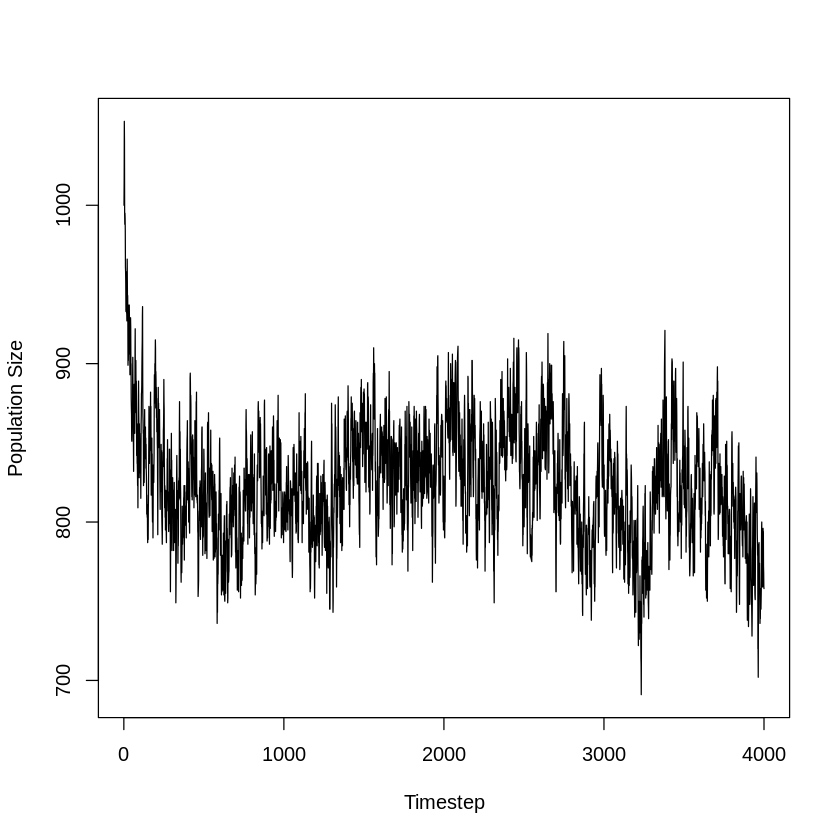

In [4]:
out <- run_sim(N0, mu, tau, NT, sld, slp, spd, spp, gender, driverGene, geneList, maxNClones, logpath)
Pop <- out[[1]]
N <- out[[2]]

# head(Pop)
N[N==0]<- NA
plot(1:NT,N,type='l',xlab='Timestep',ylab='Population Size')
# plot((1:NT)*tau,movavg(N,200,'s'),type='l',xlab='Generation',ylab='Population Size')

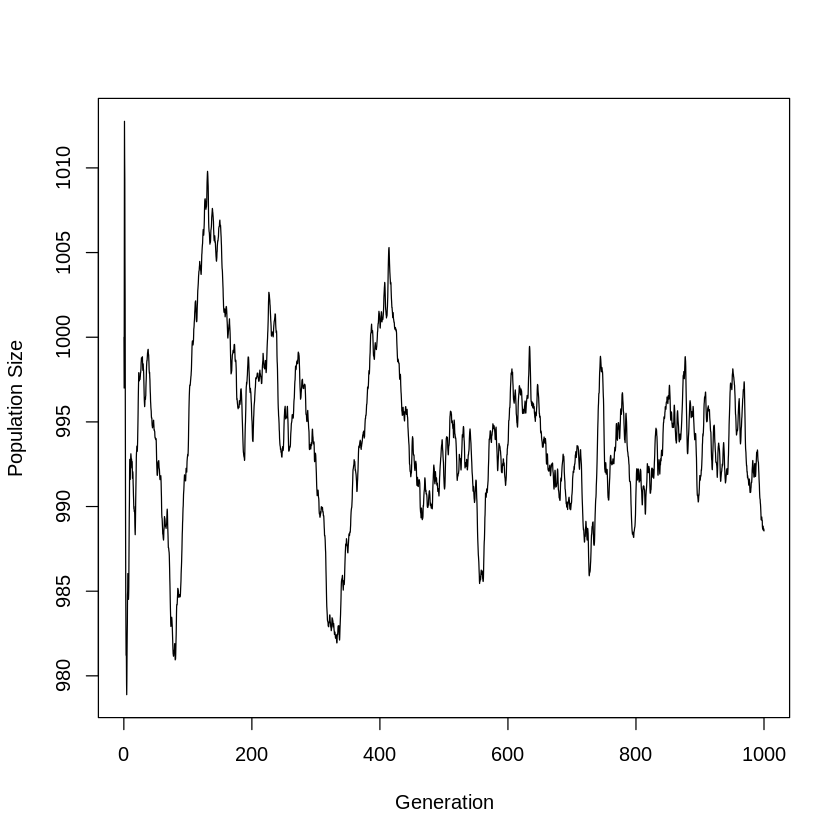

In [13]:
library(pracma)
plot((1:NT)*tau,movavg(N,200,'s'),type='l',xlab='Generation',ylab='Population Size')

## Batch run

In [ ]:
nrun <- 1800

N0v <- c(1e3,2e3)
muv <- c(0.05,0.1,0.5,1,5.00)
if (gender=='male') {
    muv_adj <- muv*(1-pd_exvsnon_m[2])
} else if (gender=='female') {
    muv_adj <- muv*(1-pd_exvsnon_f[2])
}
sdv <- c(0.005,0.01,0.050,0.1,0.500,1)
spv <- c(0.005,0.01,0.050,0.1,0.500,1)
hef <- 0.1 # Fraction of homozygous effect assigned to heterozygous mutations

outPath <- '../../brain_1008/'
logPath <- paste0(outPath,'run_2.log')

tryCatch({
    for (ii in 1:length(N0v)){
        for (jj in 1:length(muv)) {
            for (ll in 1:length(sdv)) {
                for (mm in 1:length(spv)) {
                    for (nn in 1:5) {
                        nrun <- nrun+1
                        line <- paste0('Run: ',toString(nrun),'\tN0: ',toString(N0v[ii]),'\tmu: ',toString(muv[jj]),'\tsd: ',toString(sdv[ll]),'\tsp: ',toString(spv[mm]))
                        write(line,file=logPath,append=TRUE)
                        out <- run_sim(N0v[ii], muv_adj[jj], tau, NT, sdv[ll]*hef, spv[mm]*hef, sdv[ll], spv[mm], gender, driverGene, geneList, N0v[ii]*4, logPath)
                        Pop <- out[[1]]
                        N <- out[[2]]
                        save(Pop,N,file=paste0(outPath,'run_n0',N0v[ii],'_',nrun,".rda"))
                        rm(Pop,N)
                    }
                }
            }
        }
    }
    }, warning = function(warn.msg){
        write(toString(warn.msg), logPath, append=TRUE)
    }, error = function(err.msg){
        write(toString(err.msg), logPath, append=TRUE)
    }
)